In [1]:
import glob
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from natsort import natsorted, ns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import gridspec
import statistics

In [2]:
def read_data(receptor, ligand, time_limit=0, Verbose=False, exclusions=[]):
    data = { "Receptor":[], "Ligand":[], "Jobname":[], "Time":[], "Frame":[],
            "Interface":[], "Interface_A":[], "Interface_B":[],}
    _filein = glob.glob("/home/khlee/work/desmond/output/"+receptor+"/"+ligand+"/*/")
    _filein = natsorted(_filein, key=lambda y: y.lower())
    if Verbose:
        print(_filein)
    for i in range(len(_filein)):
        if _filein[i].split("/")[-1] in exclusions:
            continue
        try:
            t = np.loadtxt(_filein[i]+'/ene/time.dat')
            frame = list(range(1,len(t)+1))
            obs = pickle.load(open(_filein[i]+'/output/gpcr_interface.p',"rb"))
            obs_a = pickle.load(open(_filein[i]+'/output/gpcr_interface_RA.p',"rb"))
            obs_b = pickle.load(open(_filein[i]+'/output/gpcr_interface_RB.p',"rb"))
        except:
            print("Job not loaded because a file was not found: ",
                  receptor+"_"+_filein[i].split("/")[-2])
            print("\n")
            continue
        
        try:
            assert (len(t)==len(obs))
            assert (len(obs) == len(obs_a))
            assert (len(obs) == len(obs_b))
            
            temp = pd.DataFrame({"obs":obs, "obs_a":obs_a, "obs_b":obs_b, "t":t, "frame":frame})
            
            sel = list(temp[temp["t"]>=time_limit]["obs"])
            sel_a = list(temp[temp["t"]>=time_limit]["obs_a"])
            sel_b = list(temp[temp["t"]>=time_limit]["obs_b"])
            sel_t = list(temp[temp["t"]>=time_limit]["t"])
            sel_frame = list(temp[temp["t"]>=time_limit]["frame"])
            
            data["Interface"] += sel
            data["Interface_A"] += sel_a
            data["Interface_B"] += sel_b
            data["Receptor"]+=[receptor for a in range(len(sel))]
            data["Ligand"]+=[ligand for a in range(len(sel))]
            data["Jobname"]+=[receptor+"_"+_filein[i].split("/")[-2].split("_")[-1] for a in range(len(sel))]
            data["Time"]+=sel_t
            data["Frame"]+=sel_frame
        except:
            print("Job not loaded because number of datapoints mismatch: ",
                  receptor+"_"+_filein[i].split("/")[-2].split("_")[-1])
            print("Time :", len(t), "Interface: ", len(obs), "Interface_A: ", len(obs_a), "Interface_B: ", len(obs_b))
            print("\n")
            continue
    
    return pd.DataFrame(data)

def check_interface(df, receptor=None):
#     difference = []
#     ab = []
#     percent_diff = []
#     for i in range(len(df)):
#         difference.append(df["Interface"][i] - (df["Interface_A"][i] + df["Interface_B"][i]))
#         ab.append(df["Interface_A"][i] + df["Interface_B"][i])
#         percent_diff.append(abs((df["Interface"][i] - (df["Interface_A"][i] + df["Interface_B"][i]))/df["Interface"][i]
#                            *100))
    df["RAB-AB"] = abs(df["Interface"] - (df["Interface_A"]+df["Interface_B"]))
    df["AB"] = df["Interface_A"]+df["Interface_B"]
    df["%Diff"] = round(df["RAB-AB"]/df["Interface"]*100,1)
    return df

def read_caller(keywords):
    df = pd.DataFrame()
    for pair in keywords:
        df = pd.concat([df,read_data(pair[0],pair[1])])
    return df



In [13]:
sel_pairs = [("d2gi", "bro"),("d2go", "bro"),
             ("d3gi", "prm"),("d3go", "prm"),
             ("d3gi", "pd"),("d3go", "pd")]

# ("drd3", "prm7"),("drd3", "pd2"),("drd3ao", "prm3"),("drd3ao", "pd2")
df = read_caller(sel_pairs)
df = check_interface(df)
df

Job not loaded because a file was not found:  d3gi_output


Job not loaded because a file was not found:  d3gi_output


Job not loaded because a file was not found:  drd3_drd3_prm7.1


Job not loaded because a file was not found:  drd3_drd3_prm7.2


Job not loaded because a file was not found:  drd3_drd3_prm7.3.1


Job not loaded because a file was not found:  drd3_drd3_prm7.3.2


Job not loaded because a file was not found:  drd3_drd3_prm7.3


Job not loaded because a file was not found:  drd3_drd3_prm7.4


Job not loaded because a file was not found:  drd3_drd3_prm7.5.1


Job not loaded because a file was not found:  drd3_drd3_prm7.5.2


Job not loaded because a file was not found:  drd3_drd3_prm7.5


Job not loaded because a file was not found:  drd3_drd3_prm7


Job not loaded because a file was not found:  drd3_output


Job not loaded because a file was not found:  drd3_drd3_pd2.1


Job not loaded because a file was not found:  drd3_drd3_pd2.2


Job not loaded because a file was no

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1,1469.0,1351.0,132.0,14.0,1483.0,1.0
1,d2gi,bro,d2gi_bro.1,0.48,2,1412.0,1331.0,88.0,7.0,1419.0,0.5
2,d2gi,bro,d2gi_bro.1,0.72,3,1471.0,1377.0,108.0,14.0,1485.0,1.0
3,d2gi,bro,d2gi_bro.1,0.96,4,1508.0,1390.0,130.0,12.0,1520.0,0.8
4,d2gi,bro,d2gi_bro.1,1.20,5,1449.0,1383.0,81.0,15.0,1464.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
26995,drd3ao,pd2,drd3ao_pd2.f6,1797.60,2996,1666.0,1563.0,103.0,0.0,1666.0,0.0
26996,drd3ao,pd2,drd3ao_pd2.f6,1798.20,2997,1669.0,1551.0,118.0,0.0,1669.0,0.0
26997,drd3ao,pd2,drd3ao_pd2.f6,1798.80,2998,1661.0,1547.0,115.0,1.0,1662.0,0.1
26998,drd3ao,pd2,drd3ao_pd2.f6,1799.40,2999,1689.0,1569.0,120.0,0.0,1689.0,0.0


In [4]:
df

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1,1469.0,1351.0,132.0,14.0,1483.0,1.0
1,d2gi,bro,d2gi_bro.1,0.48,2,1412.0,1331.0,88.0,7.0,1419.0,0.5
2,d2gi,bro,d2gi_bro.1,0.72,3,1471.0,1377.0,108.0,14.0,1485.0,1.0
3,d2gi,bro,d2gi_bro.1,0.96,4,1508.0,1390.0,130.0,12.0,1520.0,0.8
4,d2gi,bro,d2gi_bro.1,1.20,5,1449.0,1383.0,81.0,15.0,1464.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13595,d3go,pd,d3go_pd.f6,1197.60,1996,1661.0,1602.0,59.0,0.0,1661.0,0.0
13596,d3go,pd,d3go_pd.f6,1198.20,1997,1580.0,1543.0,37.0,0.0,1580.0,0.0
13597,d3go,pd,d3go_pd.f6,1198.80,1998,1621.0,1578.0,43.0,0.0,1621.0,0.0
13598,d3go,pd,d3go_pd.f6,1199.40,1999,1558.0,1507.0,51.0,0.0,1558.0,0.0


NameError: name 't' is not defined

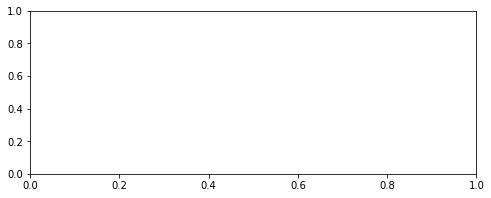

In [5]:

nrow = 1
ncol = 1
figheight = 3
figwidth = 8
linewidth = 1

fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

ax1.plot(t, RAB, label="RAB",color="red")
ax1.plot(t, AB, label="RA+RB",color="blue")
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Interface (Å)")
ax1.set_title(title)
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)



No handles with labels found to put in legend.


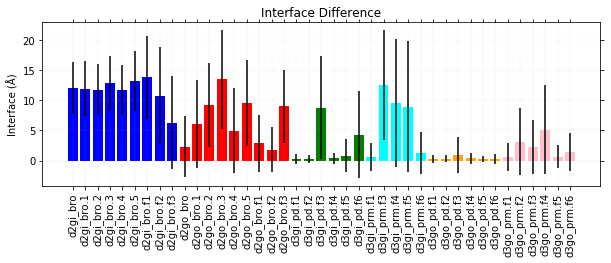

In [6]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["RAB-AB"]))
    stdev.append(statistics.stdev(indf2["RAB-AB"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



No handles with labels found to put in legend.


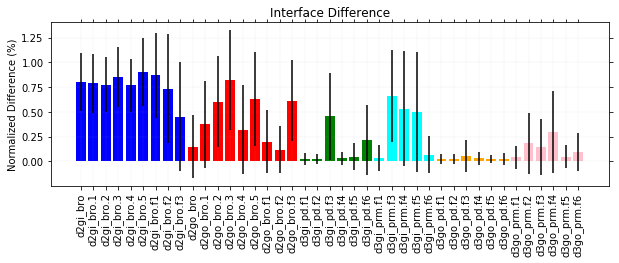

In [7]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["%Diff"]))
    stdev.append(statistics.stdev(indf2["%Diff"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Normalized Difference (%)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



No handles with labels found to put in legend.


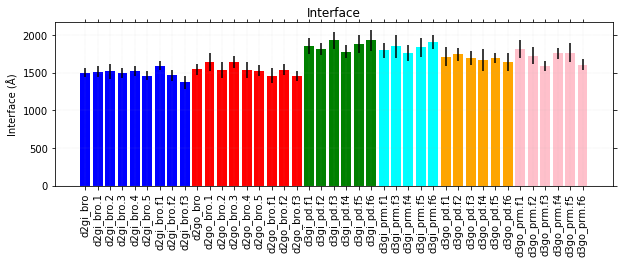

In [8]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["Interface"]))
    stdev.append(statistics.stdev(indf2["Interface"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



In [9]:
df

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1,1469.0,1351.0,132.0,14.0,1483.0,1.0
1,d2gi,bro,d2gi_bro.1,0.48,2,1412.0,1331.0,88.0,7.0,1419.0,0.5
2,d2gi,bro,d2gi_bro.1,0.72,3,1471.0,1377.0,108.0,14.0,1485.0,1.0
3,d2gi,bro,d2gi_bro.1,0.96,4,1508.0,1390.0,130.0,12.0,1520.0,0.8
4,d2gi,bro,d2gi_bro.1,1.20,5,1449.0,1383.0,81.0,15.0,1464.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13595,d3go,pd,d3go_pd.f6,1197.60,1996,1661.0,1602.0,59.0,0.0,1661.0,0.0
13596,d3go,pd,d3go_pd.f6,1198.20,1997,1580.0,1543.0,37.0,0.0,1580.0,0.0
13597,d3go,pd,d3go_pd.f6,1198.80,1998,1621.0,1578.0,43.0,0.0,1621.0,0.0
13598,d3go,pd,d3go_pd.f6,1199.40,1999,1558.0,1507.0,51.0,0.0,1558.0,0.0


In [14]:
#  output_dir_root="/home/khlee/work/desmond/output/drd3/prm7/drd3_prm7.f3"
output_dir_root="/home/khlee/desmond/output/d2gi/bro/d2gi_bro.1"
t = np.loadtxt(output_dir_root+'/ene/time.dat')
output_dir=output_dir_root+"/output"

# check
# pd.read_hdf(output_dir + '/rmsdbb_alin_OBS_backbone.hdf', 'df').head(5)

In [15]:
df = pd.read_hdf(output_dir+'/df_seg_dist_rec_ga.hdf','df')
df



,seg_dist_TM1_H2,seg_dist_TM1_H3,seg_dist_TM1_HG,seg_dist_TM1_H4,seg_dist_TM1_H5,seg_dist_TM2_H2,seg_dist_TM2_H3,seg_dist_TM2_HG,seg_dist_TM2_H4,seg_dist_TM2_H5,...,seg_dist_TM6_H2,seg_dist_TM6_H3,seg_dist_TM6_HG,seg_dist_TM6_H4,seg_dist_TM6_H5,seg_dist_TM7_H2,seg_dist_TM7_H3,seg_dist_TM7_HG,seg_dist_TM7_H4,seg_dist_TM7_H5
0,53.045726,53.142057,73.210929,60.252212,43.370467,51.476585,52.418978,71.832056,59.306012,39.418352,...,51.300258,47.959119,61.959083,49.087011,32.398726,44.966647,44.013961,63.144945,50.179958,33.315326
1,52.856309,52.908496,72.913895,59.862464,43.295757,51.529955,52.419234,71.719896,59.054477,39.381193,...,51.072557,47.700688,61.566198,48.646912,32.202199,45.168297,44.188642,63.274576,50.207613,33.687776
2,53.250735,53.035012,73.036411,59.785444,43.367799,52.192604,52.784811,72.152221,59.236512,39.798859,...,51.583158,48.078363,61.952234,48.880976,32.492560,46.011955,44.708165,63.666318,50.382297,34.053146
3,53.267495,53.071884,73.172490,60.160334,43.647905,51.602510,52.367833,72.020607,59.387887,39.869837,...,51.196303,47.804081,61.918201,49.126714,32.408451,45.509621,44.382016,63.638366,50.633017,34.066469
4,52.648147,52.399254,72.559530,59.417737,43.326957,51.420892,52.092727,71.645394,58.850238,39.653319,...,51.025176,47.587617,61.544937,48.530963,32.321448,45.192491,43.939227,63.080376,49.913337,33.763461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,52.952580,52.969979,73.513848,60.508380,44.473437,51.387509,52.111929,71.986883,59.268756,40.199652,...,52.142101,48.475386,62.504613,49.598508,33.517916,44.957160,43.797607,63.418353,50.364079,34.604648
2846,52.098638,52.422419,72.893154,60.047141,44.029964,50.972693,51.972505,71.699539,59.103122,40.071546,...,52.098284,48.847694,62.829741,49.939811,33.738475,44.324994,43.410320,62.890969,49.963583,34.322818
2847,53.277282,53.438070,73.960617,60.940464,44.872841,51.685217,52.546376,72.350558,59.608159,40.455806,...,51.961222,48.544084,62.814530,49.793478,33.656906,45.137049,44.230385,63.937896,50.872177,35.053534
2848,52.124090,52.210014,72.520704,59.529282,43.920046,50.990587,51.796563,71.352990,58.646442,40.005545,...,51.324721,47.737604,61.355029,48.397554,33.255253,44.142705,43.249210,62.767613,49.753436,34.319755


In [19]:
# SEG DIST REC/GA
df = pd.read_hdf(output_dir+'/df_seg_dist_rec_ga.hdf','df')
print(df.head(2))
# SEG DIST REC/REC
df = pd.read_hdf(output_dir+'/df_seg_dist_rec_rec.hdf','df')
print(df.head(2))

# SEG ANGLE REC/GA
df = pd.read_hdf(output_dir+'/df_seg_angle_rec_ga.hdf','df')
print(df.head(2))

# SEG ANGLE REC/GA
df = pd.read_hdf(output_dir+'/df_seg_angle_rec_rec.hdf','df')
print(df.head(2))


   seg_dist_TM1_H2  seg_dist_TM1_H3  seg_dist_TM1_HG  seg_dist_TM1_H4  \
0        53.045726        53.142057        73.210929        60.252212   
1        52.856309        52.908496        72.913895        59.862464   

   seg_dist_TM1_H5  seg_dist_TM2_H2  seg_dist_TM2_H3  seg_dist_TM2_HG  \
0        43.370467        51.476585        52.418978        71.832056   
1        43.295757        51.529955        52.419234        71.719896   

   seg_dist_TM2_H4  seg_dist_TM2_H5  ...  seg_dist_TM6_H2  seg_dist_TM6_H3  \
0        59.306012        39.418352  ...        51.300258        47.959119   
1        59.054477        39.381193  ...        51.072557        47.700688   

   seg_dist_TM6_HG  seg_dist_TM6_H4  seg_dist_TM6_H5  seg_dist_TM7_H2  \
0        61.959083        49.087011        32.398726        44.966647   
1        61.566198        48.646912        32.202199        45.168297   

   seg_dist_TM7_H3  seg_dist_TM7_HG  seg_dist_TM7_H4  seg_dist_TM7_H5  
0        44.013961        63.1449